# Solving Linear PDE using PINNs with LBFGS Optimizer which is based on the paper: 
### "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations" by Maziar Raissi, Paris Perdikaris, and George Em Karniadakis
#### [Link: https://arxiv.org/abs/1711.10561]

#### The code is inspired by the github repository of Alireza Afzal Afhaei
##### [Link: https://github.com/alirezaafzalaghaei/PINN-tutorial]

### The equation in hand is:

$$u_{t} = alpha * u_{xx}$$

#### where $a$, $b$, $c$ are constants and $f(x,t)$ is a function of $x$ and $t$, which here we have taken as $0$.

### The domain is:
$$x \in (xL, xR)\ and\ t \in (0, T]$$

### The initial condition is:
$$u(x, 0) = u0(x)$$

### The boundary conditions are:

$$u(xL, t) = uL(t)$$
$$u(xR, t) = uR(t)$$

### Importing the libraries

In [1]:
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#### Using CUDA (GPU) for faster computation, if available

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#### Preparing data points for training

In [3]:
x = torch.linspace(-torch.pi/2, torch.pi/2, 50, requires_grad=True)
t = torch.linspace(0, 1, 50, requires_grad=True)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1).to(device)
t = t.reshape(-1, 1).to(device)

#### Defining the Neural Network

In [4]:
mlp = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
).to(device)

#### Defining the optimizer

In [5]:
optimizer = optim.LBFGS(list(mlp.parameters()), lr=1e-4)

#### Defining the differentiation function

In [6]:
def dy_dx(y, x):
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

#### Defining the constants and the boundary conditions

In [7]:
xL = -torch.pi/2
xR = torch.pi/2
T = 1
alpha1 = 0.01
alpha2 = -0.01

#### Defining the loss function

In [8]:
def get_loss(alpha, x, t):
    x_t = torch.cat((x, t), 1)
    x_0 = torch.cat((x, 0 * t), 1)
    xL_t = torch.cat((xL + 0 * x, t), 1)
    xR_t = torch.cat((xR + 0 * x, t), 1)

    u = mlp.forward(x_t)
    u_t = dy_dx(u, t)
    u_x = dy_dx(u, x)
    u_xx = dy_dx(u_x, x)

    pde_loss = u_t - alpha * u_xx

    residual_init = mlp.forward(x_0)
    residual_bdy1 = mlp.forward(xL_t) - 0
    residual_bdy2 = mlp.forward(xR_t) - 0

    loss = (
        (pde_loss**2).mean()
        + (residual_init**2).mean()
        + (residual_bdy1**2).mean()
        + (residual_bdy2**2).mean()
    )
    return loss

#### Defining the closure function which will be used in the optimizer to update the weights

In [9]:
def closure1():
    loss = get_loss(alpha1, x, t)
    optimizer.zero_grad()
    loss.backward()
    return loss

def closure2():
    loss = get_loss(alpha2, x, t)
    optimizer.zero_grad()
    loss.backward()
    return loss

##### The closure function computes the loss, zeros out the gradients of the optimizer, computes the gradients of the loss with respect to the parameters and then returns the loss.

#### The main training loop (for alpha = 0.01)

In [10]:
losses1 = []

for i in range(100):
    loss1 = get_loss(alpha1, x, t)
    optimizer.step(closure1)
    losses1.append(loss1.cpu().detach().numpy())
    if i % 5 == 0:
        print("Epoch %3d: Current loss: %.2e" % (i, losses1[-1]))

Epoch   0: Current loss: 8.82e-02
Epoch   5: Current loss: 6.88e-02
Epoch  10: Current loss: 5.35e-02
Epoch  15: Current loss: 4.19e-02
Epoch  20: Current loss: 2.96e-02
Epoch  25: Current loss: 2.15e-02
Epoch  30: Current loss: 1.59e-02
Epoch  35: Current loss: 1.23e-02
Epoch  40: Current loss: 1.01e-02
Epoch  45: Current loss: 8.42e-03
Epoch  50: Current loss: 7.00e-03
Epoch  55: Current loss: 5.63e-03
Epoch  60: Current loss: 4.71e-03
Epoch  65: Current loss: 4.01e-03
Epoch  70: Current loss: 3.31e-03
Epoch  75: Current loss: 2.75e-03
Epoch  80: Current loss: 2.25e-03
Epoch  85: Current loss: 1.86e-03
Epoch  90: Current loss: 1.54e-03
Epoch  95: Current loss: 1.29e-03


#### Plotting the graph of the solution $u(x,t)$ (for alpha = 0.01)

c:\Users\Rujul\AppData\Local\Programs\PythonCodingPack\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


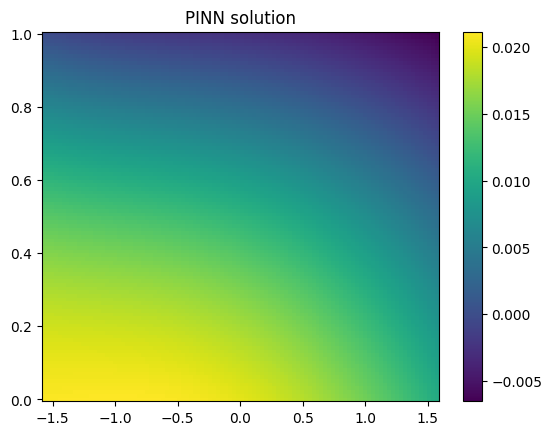

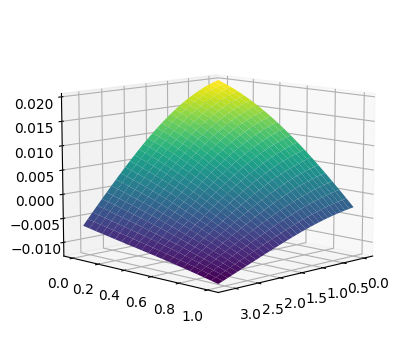

In [11]:
#PINN solution
x = torch.linspace(-torch.pi/2, torch.pi/2, 100)
t = torch.linspace(0, 1, 50, requires_grad=True)
t = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x, t)
X, T = X.to(device), T.to(device)
x_t = torch.cat((X.reshape(-1, 1), T.reshape(-1, 1)), 1)
U = mlp.forward(x_t).cpu().detach().numpy().reshape(100, 100)

plt.figure()
plt.pcolormesh(X, T, U, shading="auto")
plt.colorbar()
plt.title("PINN solution")
plt.show()

Nx, Nt = 31, 21
x = torch.linspace(0, torch.pi, Nx)
t = torch.linspace(0, 1, Nt)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)
x_t = torch.cat((x, t), 1).to(device)


predict = mlp.forward(x_t).reshape(Nx, Nt).cpu()



# MAE = torch.abs(error).mean()

# print("Mean Absolute Error: %.2e" % MAE)

x = x.reshape(Nx, Nt)
t = t.reshape(Nx, Nt)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection="3d")
ax.plot_surface(x, t, predict.detach().numpy(), cmap="viridis")
ax.view_init(10, 45)

# ax = fig.add_subplot(132, projection="3d")
# ax.plot_surface(x, t, exact.cpu().numpy(), cmap="viridis")
# ax.view_init(10, 45)


#### Reprepare the data points

In [12]:
x = torch.linspace(-torch.pi/2, torch.pi/2, 50, requires_grad=True)
t = torch.linspace(0, 1, 50, requires_grad=True)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1).to(device)
t = t.reshape(-1, 1).to(device)

#### The main training loop (for alpha = -0.01)

In [13]:
losses2 = []

for i in range(100):
    loss2 = get_loss(alpha2, x, t)
    optimizer.step(closure2)
    losses2.append(loss2.cpu().detach().numpy())
    if i % 5 == 0:
        print("Epoch %3d: Current loss: %.2e" % (i, losses2[-1]))

Epoch   0: Current loss: 1.09e-03
Epoch   5: Current loss: 8.85e-04
Epoch  10: Current loss: 6.71e-04
Epoch  15: Current loss: 5.55e-04
Epoch  20: Current loss: 5.27e-04
Epoch  25: Current loss: 5.04e-04
Epoch  30: Current loss: 4.81e-04
Epoch  35: Current loss: 4.61e-04
Epoch  40: Current loss: 4.53e-04
Epoch  45: Current loss: 4.46e-04
Epoch  50: Current loss: 4.38e-04
Epoch  55: Current loss: 4.31e-04
Epoch  60: Current loss: 4.25e-04
Epoch  65: Current loss: 4.18e-04
Epoch  70: Current loss: 4.11e-04
Epoch  75: Current loss: 4.04e-04
Epoch  80: Current loss: 3.98e-04
Epoch  85: Current loss: 3.92e-04
Epoch  90: Current loss: 3.86e-04
Epoch  95: Current loss: 3.79e-04


#### Plotting the graph of the solution $u(x,t)$ (for alpha = -0.01)

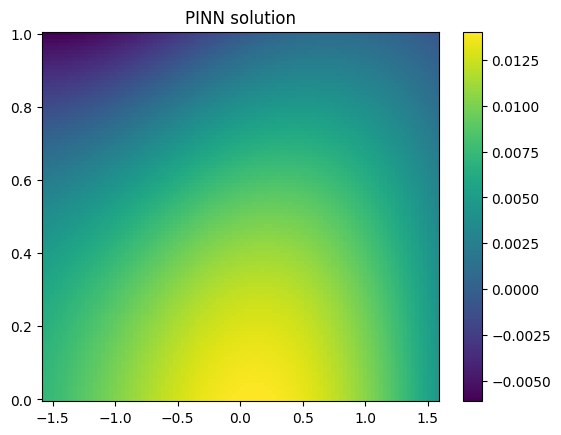

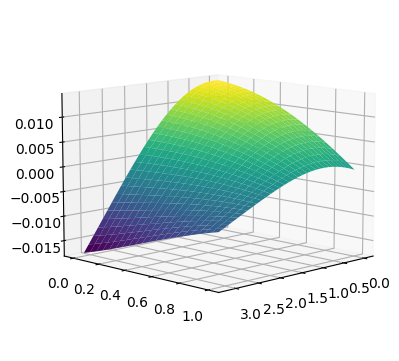

In [14]:
#PINN solution
x = torch.linspace(-torch.pi/2, torch.pi/2, 100)
t = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x, t)
X, T = X.to(device), T.to(device)
x_t = torch.cat((X.reshape(-1, 1), T.reshape(-1, 1)), 1)
U = mlp.forward(x_t).cpu().detach().numpy().reshape(100, 100)

plt.figure()
plt.pcolormesh(X, T, U, shading="auto")
plt.colorbar()
plt.title("PINN solution")
plt.show()

Nx, Nt = 31, 21
x = torch.linspace(0, torch.pi, Nx)
t = torch.linspace(0, 1, Nt)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)
x_t = torch.cat((x, t), 1).to(device)

# exact = exact_solution.reshape(Nx, Nt)
# exact = exact_solution(x.cpu().numpy(), t.cpu().numpy()).reshape(Nx, Nt)
predict = mlp.forward(x_t).reshape(Nx, Nt).cpu()
# error = exact - predict
# error = torch.tensor(exact) - predict

# MAE = torch.abs(error).mean()

# print("Mean Absolute Error: %.2e" % MAE)

x = x.reshape(Nx, Nt)
t = t.reshape(Nx, Nt)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection="3d")
ax.plot_surface(x, t, predict.detach().numpy(), cmap="viridis")
ax.view_init(10, 45)

### Things we noticed by decreasing the apha value:
#### 1. The loss value diffuses faster and smoothly
#### 2. The graph of the solution tilts more towards the left, which is because the solution is more sensitive to the boundary conditions

#### Plotting the loss function

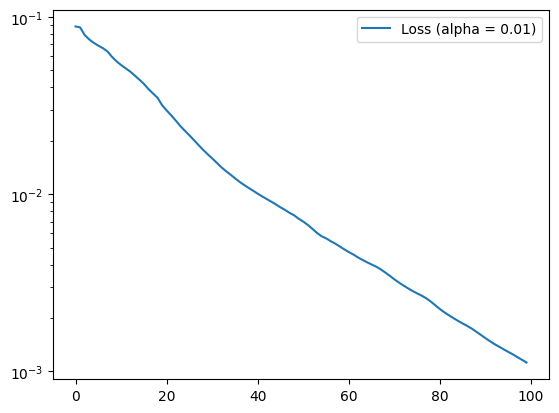

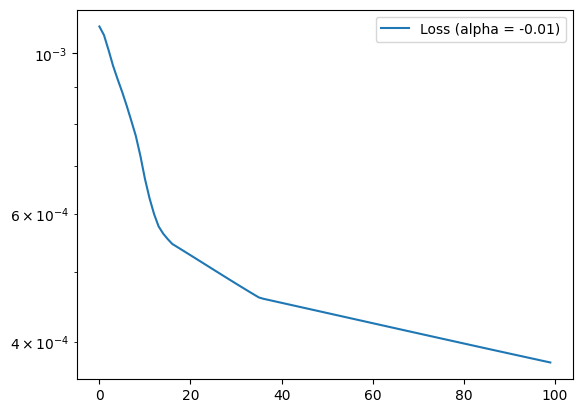

In [22]:
plt.figure()
plt.plot(losses1, label="Loss (alpha = 0.01)")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure()
plt.plot(losses2, label="Loss (alpha = -0.01)")
plt.yscale("log")
plt.legend()
plt.show()

# #Exact solution
# def exact_solution(x, t):
#     return np.exp(-a*t) * np.sin(np.pi*x) + np.exp(-3*a*t) * np.sin(3*np.pi*x)

# x = np.linspace(-1, 1, 100)
# t = np.linspace(0, 1, 100)
# X, T = np.meshgrid(x, t)
# U = exact_solution(X, T)

# plt.figure()
# plt.pcolormesh(X, T, U, shading="auto")
# plt.colorbar()
# plt.title("Exact solution")
# plt.show()

### PINN solution with no boundary conditions (advantage over FDM)

#### Reprepare the data points

In [16]:
x = torch.linspace(-torch.pi/2, torch.pi/2, 50, requires_grad=True)
t = torch.linspace(0, 1, 50, requires_grad=True)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1).to(device)
t = t.reshape(-1, 1).to(device)

#### Defining a loss function for the PINN with no boundary conditions

In [17]:
def get_loss(alpha, x, t):
    x_t = torch.cat((x, t), 1)
    x_0 = torch.cat((x, 0 * t), 1)
    # xL_t = torch.cat((-1 + 0 * x, t), 1)
    # xR_t = torch.cat((1 + 0 * x, t), 1)

    u = mlp.forward(x_t)
    u_t = dy_dx(u, t)
    u_x = dy_dx(u, x)
    u_xx = dy_dx(u_x, x)

    pde_loss = u_t - alpha * u_xx

    residual_init = mlp.forward(x_0)
    # residual_bdy1 = mlp.forward(xL_t) - 0
    # residual_bdy2 = mlp.forward(xR_t) - 0

    loss = (
        (pde_loss**2).mean()
        # +  (residual_pde**2).mean()
        + (residual_init**2).mean()
        # + (residual_bdy1**2).mean()
        # + (residual_bdy2**2).mean()
    )
    return loss

#### Defining the closure function for the optimizer

In [18]:
def closure():
    loss = get_loss(0.25, x, t)
    optimizer.zero_grad()
    loss.backward()
    return loss

#### Calculating the loss for the initial alpha value

In [19]:
losses = []

for i in range(100):
    loss = get_loss(0.25, x, t)
    optimizer.step(closure)
    losses.append(loss.cpu().detach().numpy())
    if i % 5 == 0:
        print("Epoch %3d: Current loss: %.2e" % (i, losses[-1]))

Epoch   0: Current loss: 3.26e-04


Epoch   5: Current loss: 3.26e-04
Epoch  10: Current loss: 3.26e-04
Epoch  15: Current loss: 3.25e-04
Epoch  20: Current loss: 3.25e-04
Epoch  25: Current loss: 3.25e-04
Epoch  30: Current loss: 3.25e-04
Epoch  35: Current loss: 3.25e-04
Epoch  40: Current loss: 3.25e-04
Epoch  45: Current loss: 3.25e-04
Epoch  50: Current loss: 3.25e-04
Epoch  55: Current loss: 3.25e-04
Epoch  60: Current loss: 3.25e-04
Epoch  65: Current loss: 3.25e-04
Epoch  70: Current loss: 3.25e-04
Epoch  75: Current loss: 3.25e-04
Epoch  80: Current loss: 3.25e-04
Epoch  85: Current loss: 3.25e-04
Epoch  90: Current loss: 3.25e-04
Epoch  95: Current loss: 3.25e-04


#### Plotting the graph, which looks very sharp without the boundary conditions because the boundary conditions help to smooth the solution

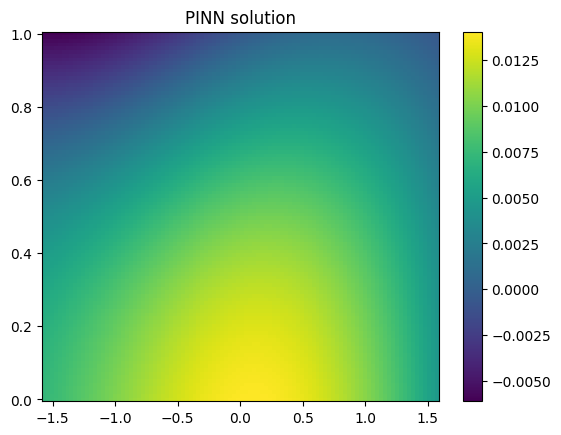

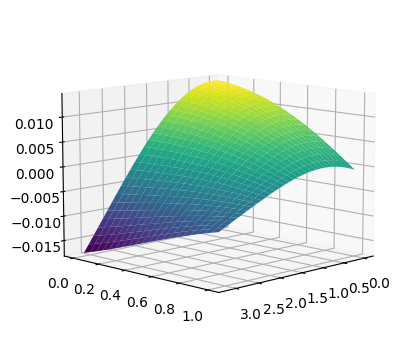

In [20]:
#PINN solution
x = torch.linspace(-torch.pi/2, torch.pi/2, 100)
t = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x, t)
X, T = X.to(device), T.to(device)
x_t = torch.cat((X.reshape(-1, 1), T.reshape(-1, 1)), 1)
U = mlp.forward(x_t).cpu().detach().numpy().reshape(100, 100)

plt.figure()
plt.pcolormesh(X, T, U, shading="auto")
plt.colorbar()
plt.title("PINN solution")
plt.show()

Nx, Nt = 31, 21
x = torch.linspace(0, torch.pi, Nx)
t = torch.linspace(0, 1, Nt)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)
x_t = torch.cat((x, t), 1).to(device)

# exact = exact_solution.reshape(Nx, Nt)
# exact = exact_solution(x.cpu().numpy(), t.cpu().numpy()).reshape(Nx, Nt)
predict = mlp.forward(x_t).reshape(Nx, Nt).cpu()
# error = exact - predict
# error = torch.tensor(exact) - predict

# MAE = torch.abs(error).mean()

# print("Mean Absolute Error: %.2e" % MAE)

x = x.reshape(Nx, Nt)
t = t.reshape(Nx, Nt)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection="3d")
ax.plot_surface(x, t, predict.detach().numpy(), cmap="viridis")
ax.view_init(10, 45)

#### Plotting the loss function

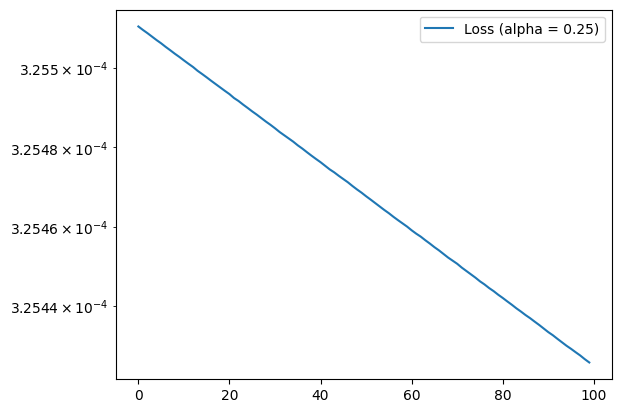

In [21]:
plt.figure()
plt.plot(losses, label="Loss (alpha = 0.25)")
plt.yscale("log")
plt.legend()
plt.show()

# #Exact solution
# def exact_solution(x, t):
#     return np.exp(-a*t) * np.sin(np.pi*x) + np.exp(-3*a*t) * np.sin(3*np.pi*x)

# x = np.linspace(-1, 1, 100)
# t = np.linspace(0, 1, 100)
# X, T = np.meshgrid(x, t)
# U = exact_solution(X, T)

# plt.figure()
# plt.pcolormesh(X, T, U, shading="auto")
# plt.colorbar()
# plt.title("Exact solution")
# plt.show()